<a href="https://colab.research.google.com/github/AlexKostjuk/dz_17/blob/master/dz_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install numpy==1.26.4

In [10]:
!pip install darts prophet statsmodels  # Встановлюємо правильні пакети


In [28]:
!pip install pmdarima


In [114]:
!pip install torch --extra-index-url https://download.pytorch.org/whl/cu118  # PyTorch із CUDA


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118


In [115]:
import torch
from torch.cuda.amp import autocast

In [ ]:
import os
os.kill(os.getpid(), 9)

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import ExponentialSmoothing, AutoARIMA, NBEATSModel
from pmdarima import auto_arima  # Для автоматичного підбору параметрів SARIMA

from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from google.colab import files


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
frb = pd.read_csv('/content/drive/MyDrive/T10Y2Y.csv', delimiter=',')


In [4]:
frb.head()

,observation_date,T10Y2Y
0,1976-06-01,0.68
1,1976-06-02,0.71
2,1976-06-03,0.70
3,1976-06-04,0.77
4,1976-06-07,0.79


In [5]:
frb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12737 entries, 0 to 12736
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  12737 non-null  object 
 1   T10Y2Y            12201 non-null  float64
dtypes: float64(1), object(1)
memory usage: 199.1+ KB


In [31]:
# Підготовка даних
frb['observation_date'] = pd.to_datetime(frb['observation_date'])
frb = frb.dropna()

In [32]:
frb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12201 entries, 0 to 12736
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   observation_date  12201 non-null  datetime64[ns]
 1   T10Y2Y            12201 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 286.0 KB


In [110]:
# Розділення на тренувальні та тестові дані за індексами
train_size = int(len(frb) * 0.9)  # 70% на тренування
train_frb = frb[:train_size]
test_frb = frb[train_size:]

In [111]:
future_period = 1000


In [112]:
# Генеруємо майбутні дати для всіх моделей
last_date = frb['observation_date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                            periods=future_period,
                            freq='B')  # Бізнес-дні

In [117]:
# --- Модель 1: Darts (NBEATS) ---
# Додаємо пропущені дати в train_frb
date_range = pd.date_range(start=train_frb['observation_date'].min(),
                          end=train_frb['observation_date'].max(),
                          freq='B')
train_frb_full = pd.DataFrame({'observation_date': date_range})
train_frb_full = train_frb_full.merge(train_frb, on='observation_date', how='left')

# Заповнюємо NaN у T10Y2Y методом forward fill
train_frb_full['T10Y2Y'] = train_frb_full['T10Y2Y'].fillna(method='ffill').fillna(method='bfill')

# Створюємо TimeSeries
train_series = TimeSeries.from_dataframe(train_frb_full, 'observation_date', 'T10Y2Y', freq='B')

# Перевірка на NaN у тренувальних даних
print("NaN in train_frb_full['T10Y2Y']:", train_frb_full['T10Y2Y'].isna().sum())

# Використовуємо NBEATS із покращеними параметрами
darts_model = NBEATSModel(
    input_chunk_length=48,  # Залишаємо
    output_chunk_length=12,  # Залишаємо
    generic_architecture=True,  # Використовуємо загальну архітектуру
    num_stacks=3,  # Кількість стеків
    num_blocks=5,  # Кількість блоків у кожному стеку
    num_layers=4,  # Кількість шарів у кожному блоці
    layer_widths=512,  # Ширина шарів
    n_epochs=40,  # Збільшуємо кількість епох для кращого навчання
    random_state=42
)
darts_model.fit(train_series)

# Прогноз на тестову вибірку + майбутнє
darts_pred = darts_model.predict(len(test_frb) + future_period)
darts_pred_values = darts_pred.values().flatten()
darts_pred_test = darts_pred_values[:len(test_frb)]  # Для оцінки на тестовій вибірці
darts_pred_future = darts_pred_values[len(test_frb):]  # Для майбутнього

# Перевірка на NaN у прогнозі
print("NaN in darts_pred_values before handling:", np.isnan(darts_pred_values).sum())
darts_pred_test = np.nan_to_num(darts_pred_test, nan=train_frb['T10Y2Y'].mean())
darts_pred_future = np.nan_to_num(darts_pred_future, nan=train_frb['T10Y2Y'].mean())

<ipython-input-117-4d4f63b46ac8>:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_frb_full['T10Y2Y'] = train_frb_full['T10Y2Y'].fillna(method='ffill').fillna(method='bfill')
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metr

NaN in train_frb_full['T10Y2Y']: 0


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

NaN in darts_pred_values before handling: 0


In [130]:
# --- Модель 1: Darts (NBEATS) на GPU T4 з оптимізацією ---
# Додаємо пропущені дати в train_frb
date_range = pd.date_range(start=train_frb['observation_date'].min(),
                          end=train_frb['observation_date'].max(),
                          freq='B')
train_frb_full = pd.DataFrame({'observation_date': date_range})
train_frb_full = train_frb_full.merge(train_frb, on='observation_date', how='left')

# Заповнюємо NaN у T10Y2Y методом ffill і bfill (виправлено застарілий метод)
train_frb_full['T10Y2Y'] = train_frb_full['T10Y2Y'].ffill().bfill()

# Створюємо TimeSeries
train_series = TimeSeries.from_dataframe(train_frb_full, 'observation_date', 'T10Y2Y', freq='B')

# Перевірка на NaN у тренувальних даних
print("NaN in train_frb_full['T10Y2Y']:", train_frb_full['T10Y2Y'].isna().sum())

# Використовуємо NBEATS із підтримкою GPU та змішаною точністю (виправлено precision)
darts_model = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    generic_architecture=True,
    num_stacks=2,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    random_state=42,
    pl_trainer_kwargs={
        "accelerator": "gpu",
        "devices": [0],
        # "precision": '32-true'  # Виправлено для змішаної точності
    } if torch.cuda.is_available() else {}
)
darts_model.fit(train_series)

# Прогноз на тестову вибірку + майбутнє
with autocast():  # Використовуємо змішану точність для прогнозу
    darts_pred = darts_model.predict(len(test_frb) + future_period)
darts_pred_values = darts_pred.values().flatten()
darts_pred_test = darts_pred_values[:len(test_frb)]  # Для оцінки на тестовій вибірці
darts_pred_future = darts_pred_values[len(test_frb):]  # Для майбутнього

# Перевірка на NaN у прогнозі
print("NaN in darts_pred_values before handling:", np.isnan(darts_pred_values).sum())
darts_pred_test = np.nan_to_num(darts_pred_test, nan=train_frb['T10Y2Y'].mean())
darts_pred_future = np.nan_to_num(darts_pred_future, nan=train_frb['T10Y2Y'].mean())

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 4.8 M  | train
-------------------------------------------------------------
4.8 M     Trainable params
2.7 K     Non-trainable params
4.8 M     Total params
19.347    Total estimated m

NaN in train_frb_full['T10Y2Y']: 0


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

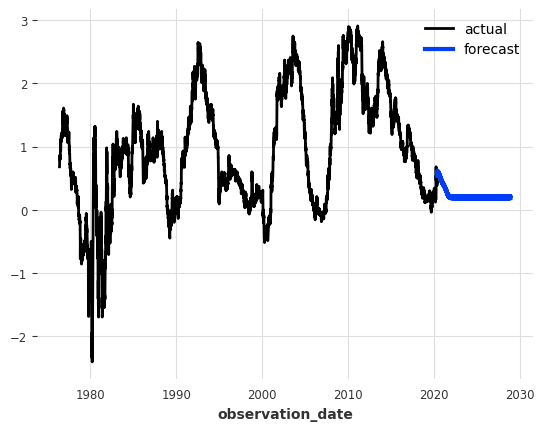

In [118]:
train_series.plot(label='actual')
darts_pred.plot(label='forecast', lw=3)
plt.legend()

In [119]:
# Перевірка на NaN у прогнозі
print("NaN in darts_pred_values before handling:", np.isnan(darts_pred_values).sum())
darts_pred_values = np.nan_to_num(darts_pred_values, nan=train_frb['T10Y2Y'].mean())

NaN in darts_pred_values before handling: 0


In [124]:
# Прогноз на тестову вибірку + майбутнє
future_period = 1000

darts_pred = darts_model.predict(len(test_frb) + future_period)
darts_pred_values = darts_pred.values().flatten()
darts_pred_test = darts_pred_values[:len(test_frb)]  # Для оцінки на тестовій вибірці
darts_pred_future = darts_pred_values[len(test_frb):]  # Для майбутнього

# Перевірка на NaN у прогнозі
print("NaN in darts_pred_values before handling:", np.isnan(darts_pred_values).sum())
darts_pred_test = np.nan_to_num(darts_pred_test, nan=train_frb['T10Y2Y'].mean())
darts_pred_future = np.nan_to_num(darts_pred_future, nan=train_frb['T10Y2Y'].mean())

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

NaN in darts_pred_values before handling: 0


In [105]:
# --- Модель 2: Prophet ---
prophet_frb = train_frb.rename(columns={'observation_date': 'ds', 'T10Y2Y': 'y'})
prophet_model = Prophet(
    daily_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.9,
    seasonality_prior_scale=1.0
)
prophet_model.fit(prophet_frb)

# Генеруємо майбутні дати (тестова вибірка + майбутнє)
future_dates_prophet = pd.DataFrame({'ds': pd.concat([pd.Series(test_frb['observation_date']),
                                                     pd.Series(future_dates)]).reset_index(drop=True)})
prophet_pred = prophet_model.predict(future_dates_prophet)
prophet_pred_values = prophet_pred['yhat'].values
prophet_pred_test = prophet_pred_values[:len(test_frb)]  # Для оцінки на тестовій вибірці
prophet_pred_future = prophet_pred_values[len(test_frb):]  # Для майбутнього
prophet_pred_test = np.nan_to_num(prophet_pred_test, nan=train_frb['T10Y2Y'].mean())
prophet_pred_future = np.nan_to_num(prophet_pred_future, nan=train_frb['T10Y2Y'].mean())


DEBUG:cmdstanpy:input tempfile: /tmp/tmpxvpk1oqn/pmonozfk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxvpk1oqn/uw_gjhgn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36633', 'data', 'file=/tmp/tmpxvpk1oqn/pmonozfk.json', 'init=/tmp/tmpxvpk1oqn/uw_gjhgn.json', 'output', 'file=/tmp/tmpxvpk1oqn/prophet_model9omaybdt/prophet_model-20250329143838.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:38:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:38:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [135]:
# --- Модель 2: Prophet (з покращеннями) ---
# Додаємо пропущені дати в train_frb для Prophet
prophet_frb = train_frb.rename(columns={'observation_date': 'ds', 'T10Y2Y': 'y'})
prophet_frb_full = pd.DataFrame({'ds': date_range})
prophet_frb_full = prophet_frb_full.merge(prophet_frb, on='ds', how='left')
# Використовуємо лінійну інтерполяцію для заповнення пропущених значень
prophet_frb_full['y'] = prophet_frb_full['y'].interpolate(method='linear')

# Ініціалізуємо Prophet із покращеними параметрами
prophet_model = Prophet(
    daily_seasonality=False,  # Вимикаємо, оскільки дані фінансові
    weekly_seasonality=False,  # Увімкнено для тижневої сезонності
    yearly_seasonality=True,  # Залишаємо річну сезонність
    changepoint_prior_scale=0.1,  # Зменшуємо для меншої чутливості до змін тренду
    seasonality_prior_scale=10.0,  # Зменшуємо для меншої сезонності
    n_changepoints=200  # Збільшуємо кількість точок зміни тренду
)

# Додаємо американські свята (можуть впливати на фінансові дані)
prophet_model.add_country_holidays(country_name='US')

# Тренуємо модель
prophet_model.fit(prophet_frb_full)

# Генеруємо майбутні дати (тестова вибірка + майбутнє)
future_dates_prophet = pd.DataFrame({'ds': pd.concat([pd.Series(test_frb['observation_date']),
                                                     pd.Series(future_dates)]).reset_index(drop=True)})
prophet_pred = prophet_model.predict(future_dates_prophet)
prophet_pred_values = prophet_pred['yhat'].values
prophet_pred_test = prophet_pred_values[:len(test_frb)]  # Для оцінки на тестовій вибірці
prophet_pred_future = prophet_pred_values[len(test_frb):]  # Для майбутнього
prophet_pred_test = np.nan_to_num(prophet_pred_test, nan=train_frb['T10Y2Y'].mean())
prophet_pred_future = np.nan_to_num(prophet_pred_future, nan=train_frb['T10Y2Y'].mean())


DEBUG:cmdstanpy:input tempfile: /tmp/tmpxvpk1oqn/dzwbk8pl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxvpk1oqn/z4puv154.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22197', 'data', 'file=/tmp/tmpxvpk1oqn/dzwbk8pl.json', 'init=/tmp/tmpxvpk1oqn/z4puv154.json', 'output', 'file=/tmp/tmpxvpk1oqn/prophet_model48edut37/prophet_model-20250329151341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:13:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:14:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [126]:
# --- Модель 3: SARIMA (з auto_arima) ---
sarima_model = auto_arima(
    train_frb['T10Y2Y'],
    seasonal=True,
    m=5,
    stepwise=True,
    trace=True
)

# Прогноз на тестову вибірку + майбутнє
sarima_pred = sarima_model.predict(n_periods=len(test_frb) + future_period)
sarima_pred_values = sarima_pred.values
sarima_pred_test = sarima_pred_values[:len(test_frb)]  # Для оцінки на тестовій вибірці
sarima_pred_future = sarima_pred_values[len(test_frb):]  # Для майбутнього
sarima_pred_test = np.nan_to_num(sarima_pred_test, nan=train_frb['T10Y2Y'].mean())
sarima_pred_future = np.nan_to_num(sarima_pred_future, nan=train_frb['T10Y2Y'].mean())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=-36149.987, Time=14.01 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=-36148.254, Time=0.96 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=-36150.777, Time=2.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=-36150.608, Time=4.23 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[5]             : AIC=-36150.253, Time=0.45 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=-36152.689, Time=0.68 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,1)[5] intercept   : AIC=-36150.773, Time=2.36 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[5] intercept   : AIC=-36148.763, Time=2.83 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[5] intercept   : AIC=-36152.250, Time=2.35 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=-36150.632, Time=2.69 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=-36152.523, Time=2.32 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[5] intercept   : AIC=-36150.328, Time=6.36 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[5]             : AIC=-36154.687, Time=0.28 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[5]             : AIC=-36152.776, Time=0.75 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,1)[5]             : AIC=-36152.772, Time=0.77 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[5]             : AIC=-36150.762, Time=0.87 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[5]             : AIC=-36154.249, Time=0.68 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[5]             : AIC=-36152.631, Time=0.56 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[5]             : AIC=-36154.522, Time=0.53 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[5]             : AIC=-36152.327, Time=2.91 sec

Best model:  ARIMA(1,1,0)(0,0,0)[5]          
Total fit time: 49.078 seconds


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [136]:
# Оцінка моделей на тестовій вибірці
actual = test_frb['T10Y2Y'].values

# Перевірка розмірів
print("Length of actual:", len(actual))
print("Length of darts_pred_test:", len(darts_pred_test))
print("Length of prophet_pred_test:", len(prophet_pred_test))
print("Length of sarima_pred_test:", len(sarima_pred_test))

# Перевірка на NaN
print("NaN in actual:", np.isnan(actual).sum())
print("NaN in darts_pred_test:", np.isnan(darts_pred_test).sum())
print("NaN in prophet_pred_test:", np.isnan(prophet_pred_test).sum())
print("NaN in sarima_pred_test:", np.isnan(sarima_pred_test).sum())

metrics = {
    'Model': ['Darts', 'Prophet', 'SARIMA'],
    'MAE': [
        mean_absolute_error(actual, darts_pred_test),
        mean_absolute_error(actual, prophet_pred_test),
        mean_absolute_error(actual, sarima_pred_test)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(actual, darts_pred_test)),
        np.sqrt(mean_squared_error(actual, prophet_pred_test)),
        np.sqrt(mean_squared_error(actual, sarima_pred_test))
    ]
}

Length of actual: 1221
Length of darts_pred_test: 1221
Length of prophet_pred_test: 1221
Length of sarima_pred_test: 1221
NaN in actual: 0
NaN in darts_pred_test: 0
NaN in prophet_pred_test: 0
NaN in sarima_pred_test: 0


In [137]:
# Виводимо результати
results_frb = pd.DataFrame(metrics)
print(results_frb)

     Model       MAE      RMSE
0    Darts  0.533682  0.642636
1  Prophet  0.694488  0.842362
2   SARIMA  0.649449  0.759273


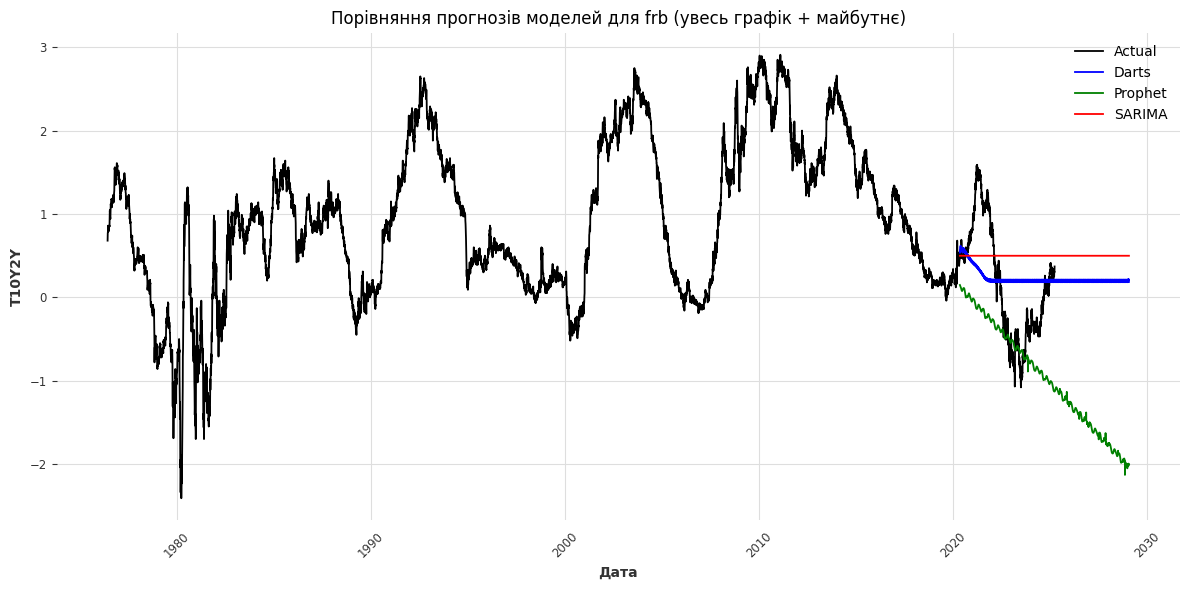

In [138]:
# Візуалізація (увесь графік + прогноз у майбутнє)
all_dates = pd.concat([pd.Series(frb['observation_date']), pd.Series(future_dates)]).reset_index(drop=True)
actual_all = frb['T10Y2Y'].values  # Усі реальні дані (тренувальні + тестові)

# Прогнози для тестової частини та майбутнього
darts_full_pred = np.concatenate([np.full(len(train_frb), np.nan), darts_pred_test, darts_pred_future])
prophet_full_pred = np.concatenate([np.full(len(train_frb), np.nan), prophet_pred_test, prophet_pred_future])
sarima_full_pred = np.concatenate([np.full(len(train_frb), np.nan), sarima_pred_test, sarima_pred_future])

plt.figure(figsize=(12, 6))
plt.plot(all_dates[:len(actual_all)], actual_all, label='Actual', color='black')
plt.plot(all_dates, darts_full_pred, label='Darts', color='blue')
plt.plot(all_dates, prophet_full_pred, label='Prophet', color='green')
plt.plot(all_dates, sarima_full_pred, label='SARIMA', color='red')
# plt.axvline(x=last_date, color='gray', linestyle='--', label='End of Actual Data')
plt.legend()
plt.title('Порівняння прогнозів моделей для frb (увесь графік + майбутнє)')
plt.xlabel('Дата')
plt.ylabel('T10Y2Y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

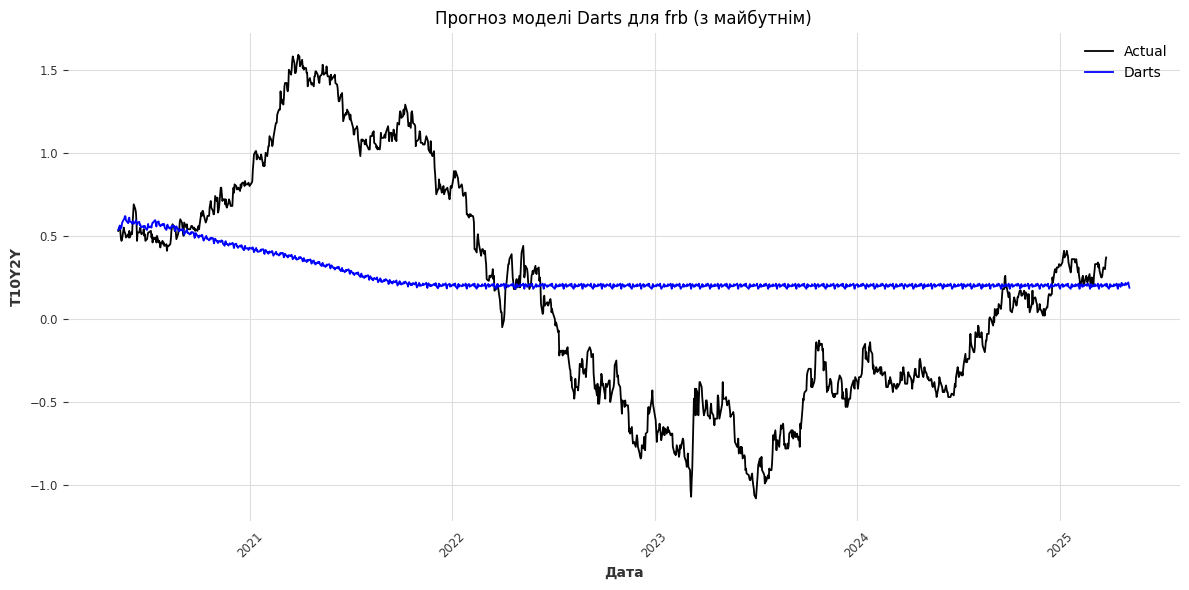

In [99]:
# Візуалізація (окремі графіки для кожної моделі)
all_dates = pd.concat([pd.Series(test_frb['observation_date']), pd.Series(future_dates)]).reset_index(drop=True)

# Графік для Darts
plt.figure(figsize=(12, 6))
plt.plot(test_frb['observation_date'], actual, label='Actual', color='black')
plt.plot(all_dates, np.concatenate([darts_pred_test, darts_pred_future]), label='Darts', color='blue')
# plt.axvline(x=last_date, color='gray', linestyle='--', label='End of Actual Data')
plt.legend()
plt.title('Прогноз моделі Darts для frb (з майбутнім)')
plt.xlabel('Дата')
plt.ylabel('T10Y2Y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
